For this code to work you need to have a folder named 'data' in the same directory as this '.ipynb' file which contains the side-by-side 3d video by the name '3dVideo1.mp4'

In [1]:
from __future__ import print_function
import numpy as np

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Activation
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D
from keras.layers import Input, BatchNormalization, ELU
import matplotlib.pyplot as plt
import keras.backend as K
from keras import layers
from keras.models import load_model
from keras.datasets import cifar10
import cv2

/home/shashwat/AnacondaResidence/anaconda3/envs/prj/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
def convresblock(x, nfeats=8, ksize=3, nskipped=2, elu=True):
   
    y0 = Conv2D(nfeats, ksize, padding='same')(x)
    y = y0
    for i in range(nskipped):
        if elu:
            y = ELU()(y)
        else:
            y = BatchNormalization(axis=1)(y)
            y = Activation('relu')(y)
        y = Conv2D(nfeats, 1, padding='same')(y)
    return layers.add([y0, y])

In [3]:
def getwhere(x):
    y_prepool, y_postpool = x
    return K.gradients(K.sum(y_postpool), y_prepool)
K.set_image_data_format('channels_first')

(1800, 32, 64, 3)


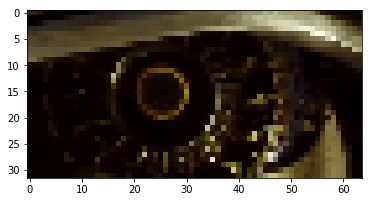

In [4]:
# input image dimensions
img_rows, img_cols = 32,64
# Code for generation of input
train_x, test_x = [], []
train_y, test_y = [], []
vid = cv2.VideoCapture('data/3dVideo1.mp4')
for i in range(2000):
    tf, frame = vid.read()
    frame1 = frame[80:640, 0:640]
    frame2 = frame[80:640, 640:1280]
    frame1 = cv2.resize(frame1, (0,0), fx=1, fy=0.5)
    frame2 = cv2.resize(frame2, (0,0), fx=1, fy=0.5)
#     frame1 = cv2.resize(frame1, (0,0), fx=0.643, fy=0.643)
#     frame2 = cv2.resize(frame2, (0,0), fx=0.643, fy=0.643)
    frame1 = frame1[0:280, 0:560]
    frame2 = frame2[0:280, 0:560]
    frame1 = cv2.resize(frame1, (0,0), fx=img_rows/280, fy=img_rows/280)
    frame2 = cv2.resize(frame2, (0,0), fx=img_rows/280, fy=img_rows/280)
#     frame1 = frame1[0:img_rows, 0:img_cols]
#     frame2 = frame2[0:img_rows, 0:img_cols]
#     frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY) 
#     frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY) 
    if i % 10 == 0:
        test_x.append(frame1)
        test_y.append(frame2)
    else:
        train_x.append(frame1)
        train_y.append(frame2)
vid.release()
cv2.destroyAllWindows()
plt.imshow(train_x[0].reshape(img_rows,img_cols,3))
cv2.imwrite('lol.png',train_x[0])
train_x = np.array(train_x)
test_x = np.array(test_x)
train_y = np.array(train_y)
test_y = np.array(test_y)
print(train_x.shape)
# x_train,x_test,y_train,y_test = train_x,test_x,train_y,test_y
def correctInput(x):
    x = x.reshape(x.shape[0], 3, img_rows, img_cols)
    x = x.astype('float32')
    x=x/255
    return x

# import matplotlib.image as mpimg
# vid = mpimg.imread("12.jpg")
# train_x = vid[0:img_rows, 0:img_cols]
# plt.imshow(train_x.reshape(32,32,3))

# print(train_x.shape)
# train_x = train_x.reshape(1,32,32,3)


x_train = correctInput(train_x)
x_test = correctInput(test_x)
y_train = correctInput(train_y)
y_test = correctInput(test_y)

#train and test size
# x_train = x_train[:100]
# x_test = x_test[:10]
# y_train = y_train[:100]
# y_test = y_test[:10]

In [5]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# The size of the kernel used for the MaxPooling2D
pool_size = 2
# The total number of feature maps at each layer
nfeats = [8, 16, 32, 64, 128]
# The sizes of the pooling kernel at each layer
pool_sizes = np.array([1, 1, 1, 1, 1]) * pool_size
# The convolution kernel size
ksize = 3
# Number of epochs to train for
epochs = 200
# Batch size during training
batch_size = 128

if pool_size == 2:
    # if using a 5 layer net of pool_size = 2
#     x_train = np.pad(x_train, [[0, 0], [0, 0], [2, 2], [2, 2]],
#                      mode='constant')
#     x_test = np.pad(x_test, [[0, 0], [0, 0], [2, 2], [2, 2]], mode='constant')
    nlayers = 5
elif pool_size == 3:
    # if using a 3 layer net of pool_size = 3
    x_train = x_train[:, :, :-1, :-1]
    x_test = x_test[:, :, :-1, :-1]
    nlayers = 3
else:
    import sys
    sys.exit('Script supports pool_size of 2 and 3.')

# Shape of input to train on (note that model is fully convolutional however)
input_shape = x_train.shape[1:]
# The final list of the size of axis=1 for all layers, including input
nfeats_all = [input_shape[0]] + nfeats

x_train shape: (1800, 3, 32, 64)
1800 train samples
200 test samples


In [6]:
# First build the encoder, all the while keeping track of the 'where' masks
img_input = Input(shape=input_shape)

# We push the 'where' masks to the following list
wheres = [None] * nlayers
y = img_input
for i in range(nlayers):
    y_prepool = convresblock(y, nfeats=nfeats_all[i + 1], ksize=ksize)
    y = MaxPooling2D(pool_size=(pool_sizes[i], pool_sizes[i]))(y_prepool)
    wheres[i] = layers.Lambda(
        getwhere, output_shape=lambda x: x[0])([y_prepool, y])

In [7]:
# Now build the decoder, and use the stored 'where' masks to place the features
for i in range(nlayers):
    ind = nlayers - 1 - i
    y = UpSampling2D(size=(pool_sizes[ind], pool_sizes[ind]))(y)
    y = layers.multiply([y, wheres[ind]])
    y = convresblock(y, nfeats=nfeats_all[ind], ksize=ksize)

In [8]:
# Use hard_simgoid to clip range of reconstruction
y = Activation('hard_sigmoid')(y)

# Define the model and it's mean square error loss, and compile it with Adam
model = Model(img_input, y)
model.compile('adam', 'mse')

# Fit the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 1800 samples, validate on 200 samples
Epoch 1/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.1223 - val_loss: 0.0993
Epoch 2/200
1800/1800 [==============================] - 48s 27ms/step - loss: 0.0854 - val_loss: 0.0737
Epoch 3/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0701 - val_loss: 0.0666
Epoch 4/200
1800/1800 [==============================] - 48s 27ms/step - loss: 0.0649 - val_loss: 0.0630
Epoch 5/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0621 - val_loss: 0.0609
Epoch 6/200
1800/1800 [==============================] - 48s 27ms/step - loss: 0.0604 - val_loss: 0.0593
Epoch 7/200
1800/1800 [==============================] - 48s 27ms/step - loss: 0.0590 - val_loss: 0.0578
Epoch 8/200
1800/1800 [==============================] - 53s 29ms/step - loss: 0.0577 - val_loss: 0.0566
Epoch 9/200
1800/1800 [==============================] - 51s 28ms/step - loss: 0.0565 - val_loss: 0.0555
Epoch 10

Epoch 78/200
1800/1800 [==============================] - 48s 27ms/step - loss: 0.0269 - val_loss: 0.0282
Epoch 79/200
1800/1800 [==============================] - 48s 27ms/step - loss: 0.0269 - val_loss: 0.0286
Epoch 80/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0272 - val_loss: 0.0281
Epoch 81/200
1800/1800 [==============================] - 48s 27ms/step - loss: 0.0269 - val_loss: 0.0279
Epoch 82/200
1800/1800 [==============================] - 48s 27ms/step - loss: 0.0266 - val_loss: 0.0277
Epoch 83/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0265 - val_loss: 0.0276
Epoch 84/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0264 - val_loss: 0.0276
Epoch 85/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0263 - val_loss: 0.0275
Epoch 86/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0262 - val_loss: 0.0275
Epoch 87/200
1800/1800 [======================

Epoch 155/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0235 - val_loss: 0.0258
Epoch 156/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0235 - val_loss: 0.0257
Epoch 157/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0235 - val_loss: 0.0257
Epoch 158/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0234 - val_loss: 0.0258
Epoch 159/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0234 - val_loss: 0.0257
Epoch 160/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0234 - val_loss: 0.0257
Epoch 161/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0234 - val_loss: 0.0257
Epoch 162/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0233 - val_loss: 0.0257
Epoch 163/200
1800/1800 [==============================] - 49s 27ms/step - loss: 0.0233 - val_loss: 0.0258
Epoch 164/200
1800/1800 [============

In [9]:
model.save('finalsave2000.h5')

In [10]:
# Plot
model = load_model('finalsave2000.h5')
x_recon = model.predict(x_test[:10])


(32, 64, 3)


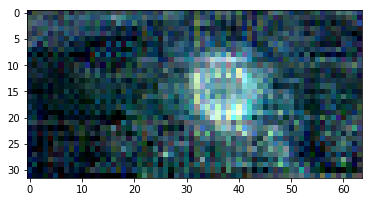

In [11]:
print(np.rollaxis(x_recon[2],0,3).shape)
img = x_recon[2].reshape(img_rows,img_cols,3)*255
img = img.astype('uint8')
cv2.imwrite('outTrained.jpg',img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

(1800, 3, 32, 64)


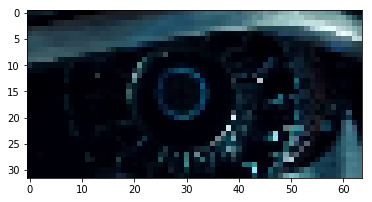

In [12]:
print(x_train.shape)
cv2.imwrite('outReal.png',x_test[2].reshape(img_rows,img_cols,3))
plt.imshow(cv2.cvtColor(train_x[2].reshape(img_rows,img_cols,3), cv2.COLOR_BGR2RGB))


In [14]:

for j in range(x_recon.shape[0]):
    img1 = x_test[j].reshape(img_rows,img_cols,3)*255
    img2 = x_recon[j].reshape(img_rows,img_cols,3)*255
    img1 = img1.astype('uint8')
    img2 = img2.astype('uint8')
    img = np.concatenate((img1, img2), axis=1)
    print(img.shape)
    cv2.imwrite("data/"+str(j)+".png",img)
import os
os.system("convert -delay 50 loop 0 data/*.png 3dvid2.gif")


(32, 128, 3)
(32, 128, 3)
(32, 128, 3)
(32, 128, 3)
(32, 128, 3)
(32, 128, 3)
(32, 128, 3)
(32, 128, 3)
(32, 128, 3)
(32, 128, 3)


256